In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchinfo import summary

BATCH_SIZE = 64
num_classes = 10
LR = 0.01
NUM_EPOCHS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data to plot accuracy and loss graphs
train_losses = [None]*NUM_EPOCHS
train_accuracy = [None]*NUM_EPOCHS

test_losses = [None]*NUM_EPOCHS
test_accuracy = [None]*NUM_EPOCHS

#%%
train_dataset = torchvision.datasets.MNIST(root = './data',train = True,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.1307,), std = (0.3081,))]), download = True)
test_dataset = torchvision.datasets.MNIST(root = './data',train = False,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [2]:
def train(train_loader, model, error_func, optimizer, epoch_no, device=None):
	
	model.to(device)
	pbar = tqdm(train_loader)
	
	train_loss_total = 0
	correct_preds_total = 0
	for b_id, (images, labels) in enumerate(pbar):
		images,labels = images.to(device), labels.to(device)
		
		#Forward pass
		outputs = model(images)
		error_batch = error_func(outputs, labels,reduction='mean')
		
		# Backward and optimize
		optimizer.zero_grad()
		error_batch.backward()
		optimizer.step()
		
		pred_labels = outputs.argmax(dim=1, keepdim=True).squeeze()
		correct_preds_batch = torch.eq(pred_labels, labels).sum().item()
		accuracy_batch = 100.0 * correct_preds_batch / BATCH_SIZE
		pbar.set_description("Train: Epoch %d, Batch= %d, Batch Error Value = %f, Batch Pred Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
		correct_preds_total = correct_preds_total + correct_preds_batch
		train_loss_total = error_batch.item()
		if (b_id + 1) % 100 == 0:
			print("Train: Epoch %d, Batch %d, Error Value = %f, Pred_Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
	train_losses[epoch_no] = train_loss_total / len(train_loader)
	train_accuracy[epoch_no] = 100.0 * correct_preds_total / len(train_loader)
	# print("T Epoch %d, Final Accuracy of the network %f" % (epoch +1 , train_accuracy[epoch_no]))

def test(test_loader, model, error_func,epoch, device=None):
	torch.set_grad_enabled(False)
	
	test_loss_total = 0
	correct_preds_total = 0
	pbar = tqdm(test_loader)
	for b_id,(images, labels) in enumerate(pbar):
		images,labels = images.to(device), labels.to(device)
		
		outputs = model(images)
		error_batch = error_func(outputs, labels, reduction='mean')
		
		pred_labels = outputs.argmax(dim=1, keepdim=True).squeeze()
		correct_preds = torch.eq(pred_labels, labels).sum().item()
		accuracy_batch = correct_preds / BATCH_SIZE * 100
		
		test_loss_total = test_loss_total + error_batch.item()
		correct_preds_total += correct_preds
		
		pbar.set_description("Test: Epoch %d, Batch= %d, Error Value = %f, Pred Acc = %f" % (epoch+1, b_id+1, error_batch.item(), accuracy_batch))
		if (b_id + 1) % 100 == 0:
			print("Test: Epoch %d, Batch %d, Error Value = %f, Pred_Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
	test_losses[epoch] = test_loss_total / len(train_loader)
	test_accuracy[epoch] = 100.0 * correct_preds_total / len(test_loader)
	print("Epoch %d, Final Accuracy of the network %f" % (epoch +1 , 100.0 * correct_preds_total / len(test_loader)))
	torch.set_grad_enabled(True)

In [3]:
class reshape(nn.Module):
	def __init__(self, pixels):
		super().__init__()
		self.pixels = pixels
		
	def forward(self, x):
		x = x.view(-1, self.pixels)
		return x
	
container = {
	"conv1": nn.Conv2d(1, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"conv2": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	
	"pool1": nn.MaxPool2d((2, 2), 2, 0),
	"conv3": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"conv4": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"pool2": nn.MaxPool2d((2, 2), 2, 0),
	
	"conv5": nn.Conv2d(32, 32, (3, 3), 1, 0),
	"relu": nn.ReLU(),
	
	"conv6": nn.Conv2d(32, 32, (3, 3), 1, 0),
	"relu": nn.ReLU(),
	
	"conv7": nn.Conv2d(32, 10, 3),
	
	"reshaper": reshape(10),
	"log_softmax": nn.LogSoftmax(dim=1),
}

In [7]:
#%%
model = nn.Sequential(*container.values())

summary(model,input_size=(1,28,28),verbose=2);

error_func = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [32, 28, 28]              320
│    └─weight                                                      ├─288
│    └─bias                                                        └─32
├─ReLU: 1-2                              [32, 28, 28]              --
├─Conv2d: 1-3                            [32, 28, 28]              9,248
│    └─weight                                                      ├─9,216
│    └─bias                                                        └─32
├─MaxPool2d: 1-4                         [32, 14, 14]              --
├─Conv2d: 1-5                            [32, 14, 14]              9,248
│    └─weight                                                      ├─9,216
│    └─bias                                                        └─32
├─Conv2d: 1-6                            [32, 14, 14]      

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/ajinkya/opt/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


In [6]:

#%%

for epoch in range(NUM_EPOCHS):
	print("epoch no= ",epoch+1)
	train(train_loader, model, error_func, optimizer,epoch)
	test(train_loader, model, error_func,epoch)

epoch no=  1


Train: Epoch 1, Batch= 103, Batch Error Value = 0.350473, Batch Pred Acc = 93.750000:  11%|█         | 102/938 [00:05<00:46, 17.85it/s]

Train: Epoch 1, Batch 100, Error Value = 0.127438, Pred_Acc = 93.750000


Train: Epoch 1, Batch= 203, Batch Error Value = 0.083736, Batch Pred Acc = 96.875000:  22%|██▏       | 202/938 [00:11<00:41, 17.75it/s] 

Train: Epoch 1, Batch 200, Error Value = 0.189139, Pred_Acc = 93.750000


Train: Epoch 1, Batch= 303, Batch Error Value = 0.257563, Batch Pred Acc = 98.437500:  32%|███▏      | 302/938 [00:17<00:37, 17.12it/s] 

Train: Epoch 1, Batch 300, Error Value = 0.058441, Pred_Acc = 96.875000


Train: Epoch 1, Batch= 403, Batch Error Value = 0.149198, Batch Pred Acc = 96.875000:  43%|████▎     | 402/938 [00:23<00:30, 17.84it/s] 

Train: Epoch 1, Batch 400, Error Value = 0.205245, Pred_Acc = 98.437500


Train: Epoch 1, Batch= 503, Batch Error Value = 0.091897, Batch Pred Acc = 95.312500:  54%|█████▎    | 502/938 [00:28<00:25, 17.37it/s] 

Train: Epoch 1, Batch 500, Error Value = 0.175275, Pred_Acc = 93.750000


Train: Epoch 1, Batch= 603, Batch Error Value = 0.318568, Batch Pred Acc = 92.187500:  64%|██████▍   | 602/938 [00:34<00:18, 17.96it/s] 

Train: Epoch 1, Batch 600, Error Value = 0.051512, Pred_Acc = 98.437500


Train: Epoch 1, Batch= 703, Batch Error Value = 0.050592, Batch Pred Acc = 98.437500:  75%|███████▍  | 702/938 [00:40<00:13, 17.93it/s] 

Train: Epoch 1, Batch 700, Error Value = 0.119528, Pred_Acc = 96.875000


Train: Epoch 1, Batch= 803, Batch Error Value = 0.236570, Batch Pred Acc = 90.625000:  86%|████████▌ | 802/938 [00:46<00:08, 15.53it/s] 

Train: Epoch 1, Batch 800, Error Value = 0.108666, Pred_Acc = 93.750000


Train: Epoch 1, Batch= 903, Batch Error Value = 0.096683, Batch Pred Acc = 98.437500:  96%|█████████▌| 902/938 [00:51<00:02, 17.45it/s] 

Train: Epoch 1, Batch 900, Error Value = 0.472803, Pred_Acc = 87.500000


Train: Epoch 1, Batch= 938, Batch Error Value = 0.088698, Batch Pred Acc = 48.437500: 100%|██████████| 938/938 [00:53<00:00, 17.39it/s]
Test: Epoch 1, Batch= 109, Error Value = 0.310452, Pred Acc = 89.062500:  11%|█         | 105/938 [00:02<00:17, 47.91it/s]

Test: Epoch 1, Batch 100, Error Value = 0.156779, Pred_Acc = 95.312500


Test: Epoch 1, Batch= 209, Error Value = 0.315575, Pred Acc = 92.187500:  22%|██▏       | 207/938 [00:04<00:15, 46.59it/s] 

Test: Epoch 1, Batch 200, Error Value = 0.243096, Pred_Acc = 93.750000


Test: Epoch 1, Batch= 309, Error Value = 0.468369, Pred Acc = 87.500000:  33%|███▎      | 307/938 [00:06<00:13, 48.42it/s] 

Test: Epoch 1, Batch 300, Error Value = 0.356846, Pred_Acc = 92.187500


Test: Epoch 1, Batch= 409, Error Value = 0.208256, Pred Acc = 92.187500:  43%|████▎     | 407/938 [00:08<00:11, 47.38it/s]

Test: Epoch 1, Batch 400, Error Value = 0.350454, Pred_Acc = 87.500000


Test: Epoch 1, Batch= 508, Error Value = 0.253949, Pred Acc = 92.187500:  54%|█████▍    | 507/938 [00:10<00:09, 47.88it/s] 

Test: Epoch 1, Batch 500, Error Value = 0.259878, Pred_Acc = 90.625000


Test: Epoch 1, Batch= 609, Error Value = 0.239830, Pred Acc = 95.312500:  65%|██████▍   | 607/938 [00:12<00:06, 47.74it/s] 

Test: Epoch 1, Batch 600, Error Value = 0.364517, Pred_Acc = 89.062500


Test: Epoch 1, Batch= 708, Error Value = 0.275322, Pred Acc = 92.187500:  75%|███████▌  | 707/938 [00:15<00:05, 44.88it/s]

Test: Epoch 1, Batch 700, Error Value = 0.247550, Pred_Acc = 90.625000


Test: Epoch 1, Batch= 809, Error Value = 0.156925, Pred Acc = 95.312500:  86%|████████▌ | 807/938 [00:17<00:02, 48.75it/s] 

Test: Epoch 1, Batch 800, Error Value = 0.296374, Pred_Acc = 92.187500


Test: Epoch 1, Batch= 909, Error Value = 0.304855, Pred Acc = 89.062500:  97%|█████████▋| 907/938 [00:19<00:00, 46.64it/s]

Test: Epoch 1, Batch 900, Error Value = 0.839900, Pred_Acc = 87.500000


Test: Epoch 1, Batch= 938, Error Value = 0.216620, Pred Acc = 42.187500: 100%|██████████| 938/938 [00:19<00:00, 46.98it/s]


Epoch 1, Final Accuracy of the network 5894.669510
epoch no=  2


Train: Epoch 2, Batch= 103, Batch Error Value = 0.295218, Batch Pred Acc = 93.750000:  11%|█         | 102/938 [00:05<00:47, 17.69it/s]

Train: Epoch 2, Batch 100, Error Value = 0.255073, Pred_Acc = 93.750000


Train: Epoch 2, Batch= 203, Batch Error Value = 0.144341, Batch Pred Acc = 96.875000:  22%|██▏       | 202/938 [00:11<00:41, 17.75it/s] 

Train: Epoch 2, Batch 200, Error Value = 0.053443, Pred_Acc = 98.437500


Train: Epoch 2, Batch= 303, Batch Error Value = 0.283184, Batch Pred Acc = 92.187500:  32%|███▏      | 302/938 [00:17<00:36, 17.56it/s] 

Train: Epoch 2, Batch 300, Error Value = 0.241318, Pred_Acc = 90.625000


Train: Epoch 2, Batch= 403, Batch Error Value = 0.446750, Batch Pred Acc = 85.937500:  43%|████▎     | 402/938 [00:23<00:31, 16.79it/s] 

Train: Epoch 2, Batch 400, Error Value = 0.221039, Pred_Acc = 93.750000


Train: Epoch 2, Batch= 503, Batch Error Value = 0.225990, Batch Pred Acc = 93.750000:  54%|█████▎    | 502/938 [00:28<00:24, 18.06it/s] 

Train: Epoch 2, Batch 500, Error Value = 0.255235, Pred_Acc = 93.750000


Train: Epoch 2, Batch= 603, Batch Error Value = 0.391375, Batch Pred Acc = 95.312500:  64%|██████▍   | 602/938 [00:34<00:18, 17.92it/s] 

Train: Epoch 2, Batch 600, Error Value = 0.113307, Pred_Acc = 96.875000


Train: Epoch 2, Batch= 703, Batch Error Value = 0.405324, Batch Pred Acc = 92.187500:  75%|███████▍  | 702/938 [00:40<00:13, 17.76it/s] 

Train: Epoch 2, Batch 700, Error Value = 0.202116, Pred_Acc = 96.875000


Train: Epoch 2, Batch= 803, Batch Error Value = 0.433999, Batch Pred Acc = 87.500000:  86%|████████▌ | 802/938 [00:45<00:07, 17.56it/s] 

Train: Epoch 2, Batch 800, Error Value = 0.166763, Pred_Acc = 98.437500


Train: Epoch 2, Batch= 903, Batch Error Value = 9454.678711, Batch Pred Acc = 12.500000:  96%|█████████▌| 902/938 [00:51<00:02, 17.67it/s] 

Train: Epoch 2, Batch 900, Error Value = 7142.651855, Pred_Acc = 7.812500


Train: Epoch 2, Batch= 938, Batch Error Value = 804.532349, Batch Pred Acc = 12.500000: 100%|██████████| 938/938 [00:53<00:00, 17.56it/s]  
Test: Epoch 2, Batch= 110, Error Value = 593.067993, Pred Acc = 12.500000:  11%|█         | 105/938 [00:02<00:17, 48.99it/s]

Test: Epoch 2, Batch 100, Error Value = 617.577148, Pred_Acc = 10.937500


Test: Epoch 2, Batch= 209, Error Value = 819.333801, Pred Acc = 6.250000:  22%|██▏       | 205/938 [00:04<00:14, 49.08it/s] 

Test: Epoch 2, Batch 200, Error Value = 656.792358, Pred_Acc = 9.375000


Test: Epoch 2, Batch= 310, Error Value = 744.878418, Pred Acc = 10.937500:  33%|███▎      | 306/938 [00:06<00:12, 49.29it/s]

Test: Epoch 2, Batch 300, Error Value = 640.389587, Pred_Acc = 15.625000


Test: Epoch 2, Batch= 408, Error Value = 607.544861, Pred Acc = 9.375000:  43%|████▎     | 405/938 [00:08<00:11, 45.40it/s] 

Test: Epoch 2, Batch 400, Error Value = 688.397827, Pred_Acc = 9.375000


Test: Epoch 2, Batch= 509, Error Value = 650.129028, Pred Acc = 9.375000:  54%|█████▍    | 508/938 [00:10<00:08, 48.71it/s] 

Test: Epoch 2, Batch 500, Error Value = 657.557495, Pred_Acc = 12.500000


Test: Epoch 2, Batch= 609, Error Value = 616.879639, Pred Acc = 14.062500:  64%|██████▍   | 604/938 [00:12<00:06, 49.33it/s]

Test: Epoch 2, Batch 600, Error Value = 702.325745, Pred_Acc = 10.937500


Test: Epoch 2, Batch= 709, Error Value = 588.870544, Pred Acc = 7.812500:  76%|███████▌  | 709/938 [00:14<00:04, 48.65it/s] 

Test: Epoch 2, Batch 700, Error Value = 723.893188, Pred_Acc = 10.937500


Test: Epoch 2, Batch= 810, Error Value = 620.920044, Pred Acc = 15.625000:  86%|████████▌ | 808/938 [00:16<00:02, 49.90it/s]

Test: Epoch 2, Batch 800, Error Value = 695.598755, Pred_Acc = 7.812500


Test: Epoch 2, Batch= 909, Error Value = 606.506653, Pred Acc = 6.250000:  97%|█████████▋| 909/938 [00:18<00:00, 49.21it/s] 

Test: Epoch 2, Batch 900, Error Value = 589.653076, Pred_Acc = 17.187500


Test: Epoch 2, Batch= 938, Error Value = 507.714661, Pred Acc = 9.375000: 100%|██████████| 938/938 [00:19<00:00, 48.29it/s] 

Epoch 2, Final Accuracy of the network 703.944563


Text(0.5, 1.0, 'Test Accuracy')

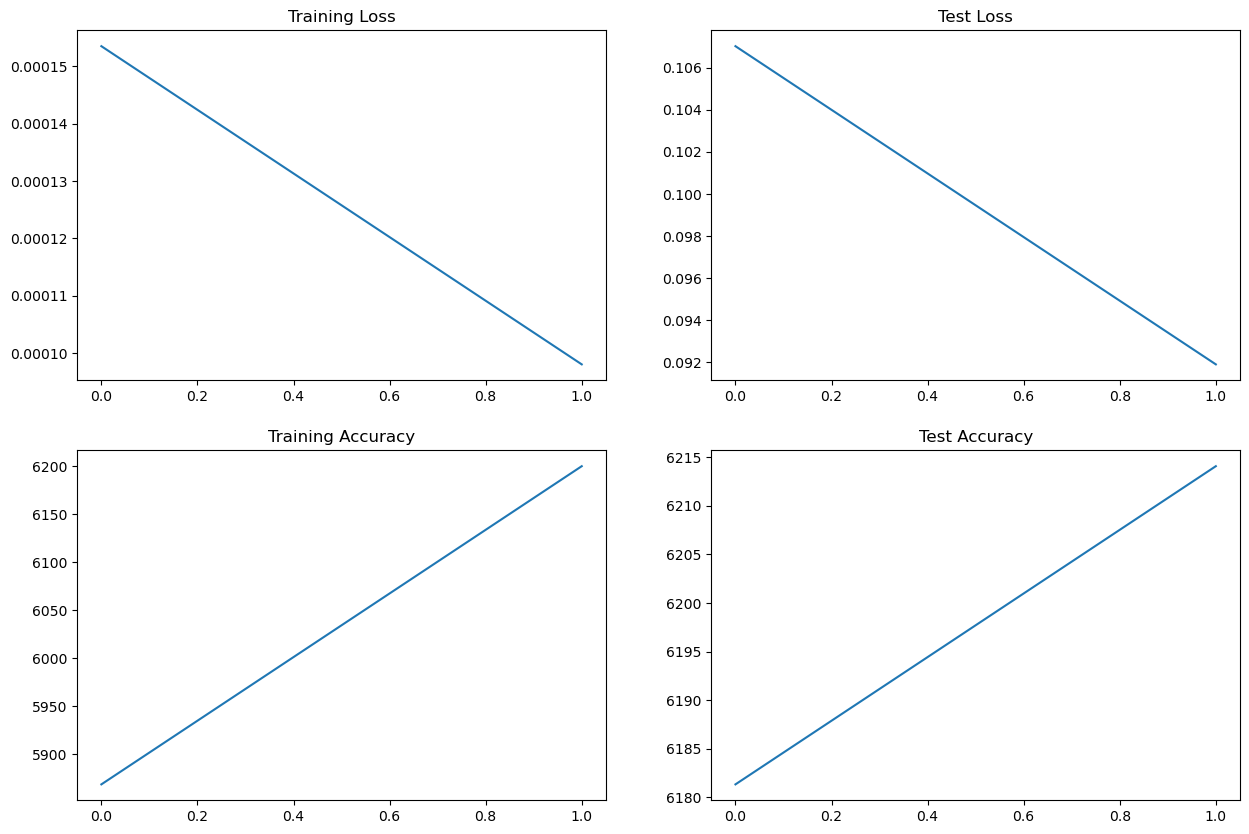

In [5]:
#%%
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")